# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [5]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg

# My own script (an interface to the simulator)
import ae353_spacecraft

In [6]:
simulator = ae353_spacecraft.Simulator(
    display=False,
    seed=27,
)

The right ascension and declination of 7 stars in the constellation to be observed by the startracker is defined below.

In [7]:
ra = []
dec = []
for (i, star) in enumerate(simulator.stars):
    ra.append(star['alpha'])
    dec.append(star['delta'])
    print(f'star {i} : alpha = {star["alpha"]:5.2f} : delta = {star["delta"]:5.2f}')

star 0 : alpha = -0.10 : delta = -0.15
star 1 : alpha =  0.00 : delta = -0.15
star 2 : alpha =  0.10 : delta = -0.15
star 3 : alpha =  0.00 : delta =  0.00
star 4 : alpha = -0.10 : delta =  0.15
star 5 : alpha =  0.00 : delta =  0.15
star 6 : alpha =  0.10 : delta =  0.15


# Define the Equations of Motion


Define Physical Parameters

In [8]:
# Mass and MOI of base
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

# Mass and MOI of each wheel
mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

Derive the Equation of Motion

In [9]:
# Define yaw, pitch, roll yaw angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# Define MOI of spacecraft and wheels together
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right)$$

Here is the function $f$:

In [10]:
f

Matrix([
[                        (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                     w_y*cos(phi) - w_z*sin(phi)],
[         w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-55*sqrt(2)*tau_1/1484 + 55*sqrt(2)*tau_2/1484 - 150*w_y*w_z/371],
[-55*sqrt(2)*tau_3/1484 + 55*sqrt(2)*tau_4/1484 + 150*w_x*w_z/371],
[                -55*sqrt(2)*(tau_1 + tau_2 + tau_3 + tau_4)/2084]])

## Sensor Model

In [11]:
alpha, delta = sym.symbols('alpha, delta')

# Define the Physical Parameters
# Scope radius
r = 0.8 / 2.1

## Derive the Sensor Model for an Arbitrary Star

The sensor model has this form for each star:

$$\zeta = g(\psi, \theta, \phi, \alpha, \delta)$$

The resulting function for $g$ accounting for all 7 stars is shown below:

In [13]:
def g_matrix(alpha,delta):
    # Position of star in space frame
    p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                                  [sym.sin(alpha) * sym.cos(delta)],
                                  [sym.sin(delta)]])

    # Orientation of body frame in space frame
    R_body_in_space = Rz * Ry * Rx

    # Position of star in body frame (assuming origin of body and space frames are the same)
    p_star_in_body = R_body_in_space.T * p_star_in_space

    # Position of star in image frame
    p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                           [p_star_in_body[2] / p_star_in_body[0]]])

    # Sensor model for each star
    g = sym.simplify(p_star_in_image, full=True)
    return g

Derive the Sensor Model for all 7 Stars in Constellation from Right Ascension and Declination Data

In [14]:
gs = []
for i in range(len(ra)):
    matrix_g = g_matrix(ra[i],dec[i])
    gs.append(matrix_g)
g = sym.Matrix(np.array([
    [gs[0][0]],
    [gs[0][1]],
    [gs[1][0]],
    [gs[1][1]],
    [gs[2][0]],
    [gs[2][1]],
    [gs[3][0]],
    [gs[3][1]],
    [gs[4][0]],
    [gs[4][1]],
    [gs[5][0]],
    [gs[5][1]],
    [gs[6][0]],
    [gs[6][1]],
]))
    

In [15]:
from sympy.physics import mechanics
mechanics.init_vprinting()
symg = sym.Matrix(g)
#print(f'{mechanics.mlatex(symg)}')

The entire function $g$ is shown below:

In [16]:
g

⎡-2.07296029483037⋅sin(φ)⋅sin(ψ)⋅sin(θ) + 20.6604581621089⋅sin(φ)⋅sin(θ)⋅cos(ψ
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                           -0.789699159935378⋅sin(ψ)⋅cos(θ) +
⎢                                                                             
⎢20.6604581621089⋅sin(φ)⋅sin(ψ) + 2.07296029483037⋅sin(φ)⋅cos(ψ) - 2.072960294
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                          -0.789699159935378⋅sin(ψ)⋅cos(θ) + 
⎢                                                                             
⎢                                     20.7641926366569⋅sin(φ)⋅sin(θ)⋅cos(ψ) - 
⎢                                     ────────────────────────────────────────
⎢                                                             1.19550505978879
⎢                                                                             
⎢                                     20.76419263665

## Generate State-space Model:

The goal of the spacecraft is to stay at the point equilibrium point where the yaw, pitch and roll are all zero. For this reasion, it is important to define the equilibrium values properly.

Thus, the function $f$ for the controller reaches equilibrium at some point $(\psi_{eq},\theta_{eq},\phi_{eq},w_{x,eq},w_{y,eq},w_{z,eq},\tau_{1,eq},\tau_{2,eq},\tau_{3,eq},\tau_{4,eq})$ where:

$$f(\psi_{eq},\theta_{eq},\phi_{eq},w_{x,eq},w_{y,eq},w_{z,eq},\tau_{1,eq},\tau_{2,eq},\tau_{3,eq},\tau_{4,eq}) = \begin{bmatrix} 0\\0\\0\\0\\0\\0\\0\\0\\0\\0 \end{bmatrix}$$


Similarly, 

In [21]:
# define equilibrium
psi_e = 0
theta_e = 0
phi_e = 0

w_x_e = 0
w_y_e = 0
w_z_e = 0

tau_1_e = 0
tau_2_e = 0
tau_3_e = 0
tau_4_e = 0

x_eq = np.array([
    psi_e,
    theta_e,
    phi_e,
    w_x_e,
    w_y_e,
    w_z_e     
        ])
u_eq = np.array([
    tau_1_e,
    tau_2_e,
    tau_3_e,
    tau_4_e
])

# check equilibrium
f_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],f)
print('f_num_eq =',f_num(psi_e,theta_e,phi_e,w_x_e,w_y_e,w_z_e,tau_1_e,tau_2_e,tau_3_e,tau_4_e)) 
# output should be zero

print(' ')
g_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],g)
print('g_num_eq =',g_num(psi_e,theta_e,phi_e,w_x_e,w_y_e,w_z_e,tau_1_e,tau_2_e,tau_3_e,tau_4_e)) 
# output shouldnt be zero 

f_num_eq = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]]
 
g_num_eq = [[-0.26337851]
 [-0.3987219 ]
 [ 0.        ]
 [-0.39672995]
 [ 0.26337851]
 [-0.3987219 ]
 [ 0.        ]
 [ 0.        ]
 [-0.26337851]
 [ 0.3987219 ]
 [-0.        ]
 [ 0.39672995]
 [ 0.26337851]
 [ 0.3987219 ]]


## Find A and B and C Matrices

To linearize a model as a set of first order ODEs, to satisfy $$\dot{x}=Ax+Bu$$ $A$ is found by taking the Jacobian of $f$ with respect to the state, and $B$ is found by taking the Jacobian of $f$ with respect to the output. Similarly, to linearize the sensor model, the constant $C$ is found by taking the Jacobian of $g$ with respect to the state. 
$$ A=\dfrac{\partial f}{\partial x}\bigg|_{(x_{eq},u_{eq})}$$  $$B=\dfrac{\partial f}{\partial u}\bigg|_{(x_{eq},u_{eq})}$$ $$C=\dfrac{\partial g}{\partial x}\bigg|_{(x_{eq},u_{eq})}$$

In [22]:
# Assemble state and input matrices
A_num = sym.lambdify((psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4), f.jacobian([psi,theta,phi,w_x,w_y,w_z]))
B_num = sym.lambdify((psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4), f.jacobian([tau_1,tau_2,tau_3,tau_4]))
C_num = sym.lambdify((psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4), g.jacobian([psi,theta,phi,w_x,w_y,w_z])) 

A = A_num(psi_e,theta_e,phi_e,w_x_e,w_y_e,w_z_e,tau_1_e,tau_2_e,tau_3_e,tau_4_e)
B = B_num(psi_e,theta_e,phi_e,w_x_e,w_y_e,w_z_e,tau_1_e,tau_2_e,tau_3_e,tau_4_e)
C = C_num(psi_e,theta_e,phi_e,w_x_e,w_y_e,w_z_e,tau_1_e,tau_2_e,tau_3_e,tau_4_e)

print('A = ',A)
print(' ')
print('B = ',B)
print(' ')
print('C = ',C)

A =  [[ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1. -0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
 
B =  [[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.05241358  0.05241358  0.          0.        ]
 [ 0.          0.         -0.05241358  0.05241358]
 [-0.03732329 -0.03732329 -0.03732329 -0.03732329]]
 
C =  [[-2.651426    0.04000563 -0.3987219   0.          0.          0.        ]
 [-0.04000563  2.68556349  0.26337851  0.          0.          0.        ]
 [-2.625       0.         -0.39672995  0.          0.          0.        ]
 [ 0.          2.68495987  0.          0.          0.          0.        ]
 [-2.651426   -0.04000563 -0.3987219   0.          0.          0.        ]
 [ 0.04000563  2.68556349 -0.26337851  0.          0.          0.        ]
 [-2.625       0.          0.          0.          0.        

## Controllability

The spacecraft must be checked for controllability before we begin to control it. To do this, the controllability matrix $W$ is found by $$W = [\,B \quad  AB \quad A^2 B \quad A^3 B \quad A^4 B \quad A^5 B]$$ If $W$ is full rank, the spacecraft is controllable.

In [25]:
# Construct Controllability Matrix W
W = B
n = A.shape[0]

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

# determines if a system is controllable or not    
def is_controllable(A,B):
    W = B
    n = A.shape[0]

    for i in range(1, n):
        col = np.linalg.matrix_power(A, i) @ B
        W = np.block([W, col])
    r = np.linalg.matrix_rank(W)
    if r==W.shape[0]:
        return print('Controllable!')
    else:
        return print('Not Controllable!')
is_controllable(A,B)
W

Controllable!


array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.03732329,
        -0.03732329, -0.03732329, -0.03732329,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.05241358,  0.05241358,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.05241358,
         0.05241358,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
  

## Observability

Similiar to the controllability matrix, an observability matrix $O$ is found in order to determine if the sensor is observable. $O$ is found by $$O = [\,C^T \quad  A^T C^T \quad (A^T)^2 C^T \quad (A^T)^3 C^T \quad (A^T)^4 C^T \quad (A^T)^5 C^T]$$

In [26]:
def is_observable(A,C):
    A = A.T
    C = C.T
    O = C
    n = A.shape[0]

    for i in range(1, n):
        col = np.linalg.matrix_power(A, i) @ C
        O = np.block([O, col])
    r = np.linalg.matrix_rank(O)
    if r==O.shape[0]:
        return print('Observable!')
    else:
        return print('Not Observable!')
is_observable(A,C)

Observable!


## Linear Quadratic Regulator (LQR) Control Design

We used Linear Quadratic Regulator (LQR) control design to weigh the importance of variables in our system. The infinite-horizon LQR optimal control problem is written as:


$$
\begin{aligned}
\underset{u_{[t_{0},\infty]}}{\text{minimize}} &\qquad \int_{t_{0}}^{\infty}\left( x(t)^{T}Qx(t)+u(t)^{T}Ru(t)\right)dt \\
\text{subject to} &\qquad \dot{x}(t) = Ax(t)+Bu(t), \quad x(t_{0})=x_{0}
\end{aligned}
$$

The integrand is cost. Evaluating this integral finds total cost. Matrices $Q$ and $R$ are the weights we choose for variables in our system. The limits on initial conditions, $x_{0}$, will be tested later. The input that achieves minimum total cost is $u$, which can be written as:

$$
u(t) = -Kx(t)
$$

The minimum total cost is

$$
x_{0}^{T}Px_{0}
$$

where $P$ is the solution to the Riccati equation:

$$A^{T}P + PA - PBR^{-1}B^{T}P+Q=0$$

The optimal gain matrix $K$ can then be found as:

$$ K = R^{-1} B^{T} P $$

## Finding K

In [35]:
# Construct K
from sympy.physics import mechanics
mechanics.init_vprinting()
symg = sym.Matrix(g)
#print(f'{mechanics.mlatex(symg)}')

# Define the weights

QK = np.eye(len(A[0]))
QK[0,0] = 2000     # psi weight
QK[1,1] = 7000     # theta weight
QK[2,2] = 1000     # phi weight
QK[3,3] = 1000     # w_x weight
QK[4,4] = 7000     # w_y weight
QK[5,5] = 2000     # w_z weight


RK = np.eye(4)*.0025


# Find the optimal cost matrix and gain matrix (both should be 2D NumPy arrays)
PK = linalg.solve_continuous_are(A, B, QK, RK)

K = linalg.inv(RK) @  B.T @ PK


$$Q_K = \left[\begin{matrix}2000.0 & 0 & 0 & 0 & 0 & 0\\0 & 7000.0 & 0 & 0 & 0 & 0\\0 & 0 & 1000.0 & 0 & 0 & 0\\0 & 0 & 0 & 1000.0 & 0 & 0\\0 & 0 & 0 & 0 & 7000.0 & 0\\0 & 0 & 0 & 0 & 0 & 2000.0\end{matrix}\right]$$

$$R_K = \left[\begin{matrix}0.0025 & 0 & 0 & 0\\0 & 0.0025 & 0 & 0\\0 & 0 & 0.0025 & 0\\0 & 0 & 0 & 0.0025\end{matrix}\right]$$

$$P_K = \left[\begin{matrix}2029.73436078263 & 2.22113836666014 \cdot 10^{-12} & -7.07411340533293 \cdot 10^{-13} & -3.97119048201131 \cdot 10^{-13} & 1.95699159936383 \cdot 10^{-12} & 29.9553938354175\\2.22113836666014 \cdot 10^{-12} & 7056.21083195916 & 9.00895580095217 \cdot 10^{-13} & 4.08740442080426 \cdot 10^{-13} & 56.4365217898415 & 2.12265658617131 \cdot 10^{-12}\\-7.07411340533293 \cdot 10^{-13} & 9.00895580095217 \cdot 10^{-13} & 1021.108221705 & 21.3310002167713 & 4.14080043382291 \cdot 10^{-13} & -4.15209911680417 \cdot 10^{-13}\\-3.97119048201131 \cdot 10^{-13} & 4.08740442080426 \cdot 10^{-13} & 21.3310002167713 & 21.781259698536 & 4.19945402311703 \cdot 10^{-13} & -5.55470146595375 \cdot 10^{-13}\\1.95699159936383 \cdot 10^{-12} & 56.4365217898415 & 4.14080043382291 \cdot 10^{-13} & 4.19945402311703 \cdot 10^{-13} & 56.8897137673679 & 1.949107979769 \cdot 10^{-12}\\29.9553938354175 & 2.12265658617131 \cdot 10^{-12} & -4.15209911680417 \cdot 10^{-13} & -5.55470146595375 \cdot 10^{-13} & 1.949107979769 \cdot 10^{-12} & 30.400746079262\end{matrix}\right] $$

$$K = \left[\begin{matrix}-447.213595500014 & -4.02592340297234 \cdot 10^{-11} & -447.213595499933 & -456.653479223228 & -3.79031885358691 \cdot 10^{-11} & -453.862400697765\\-447.21359550003 & -2.31203956375788 \cdot 10^{-11} & 447.213595499946 & 456.653479223245 & -2.02945165211526 \cdot 10^{-11} & -453.862400697788\\-447.213595500063 & -1183.2159566199 & -2.48256549377218 \cdot 10^{-12} & -5.11545639897509 \cdot 10^{-13} & -1192.71732137831 & -453.862400697817\\-447.213595499981 & 1183.21595661984 & 1.48801669748317 \cdot 10^{-11} & 1.70971263748189 \cdot 10^{-11} & 1192.71732137825 & -453.862400697735\end{matrix}\right]$$

## Determine if System is Stable
To ensure the $K$ matrix we found gives us an asymptotically stable system (as time reaches infinity, the system will reach equilibrium), all real values of the eigenvalues for $F=A-BK$ must be less than zero

In [36]:

F = A-B@K
s = linalg.eigvals(F)
if (s.real < 0).all():
    print("Asymptotically Stable")

Asymptotically Stable


## Find L

## Linear Quadratic Regulator (LQR) Control Design

We used Linear Quadratic Regulator (LQR) control design once again to find the $L$ matrix to optimize the observer. Using the optimal observer derivation (AKA the Kalman Filter), it was found that the same approach can be used to find $L$ as $K$, but the only difference is the shape of $Q$ and $R$, and that $K$ is replaced with $L^T$, $A$ is replaced with $A^T$, $B$ is replaced with $C^T$, $Q_C$ is replaced with $R_o^{-1}$, and $R_C$ is replaced with $Q_o^{-1}$


In [47]:
# Construct L

# Define the weights
Q_obs = np.eye(14)

R_obs = np.eye(6)*1

# Find the optimal cost matrix and gain matrix 
P_obs = linalg.solve_continuous_are(A.T, C.T, linalg.inv(R_obs), linalg.inv(Q_obs))

L = P_obs@C.T@Q_obs

$$Q_{obs} = \left[\begin{array}{cccccccccccccc}1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0\end{array}\right]$$

$$R_{obs} = \left[\begin{matrix}1.0 & 0 & 0 & 0 & 0 & 0\\0 & 1.0 & 0 & 0 & 0 & 0\\0 & 0 & 1.0 & 0 & 0 & 0\\0 & 0 & 0 & 1.0 & 0 & 0\\0 & 0 & 0 & 0 & 1.0 & 0\\0 & 0 & 0 & 0 & 0 & 1.0\end{matrix}\right]$$

$$P_{obs} = \left[\begin{matrix}0.162356029277866 & -1.79524073160695 \cdot 10^{-17} & -6.92571327509601 \cdot 10^{-17} & -3.59794281398604 \cdot 10^{-17} & 1.85687832838459 \cdot 10^{-17} & 0.143151760104251\\-1.79524073160695 \cdot 10^{-17} & 0.159886590965913 & -2.48988401239428 \cdot 10^{-17} & 2.25382787866887 \cdot 10^{-17} & 0.141189922824435 & 1.23466375590188 \cdot 10^{-17}\\-6.92571327509601 \cdot 10^{-17} & -2.48988401239428 \cdot 10^{-17} & 1.51116024415149 & 0.90233787951827 & -6.36963585553833 \cdot 10^{-16} & -2.44762283277168 \cdot 10^{-16}\\-3.59794281398604 \cdot 10^{-17} & 2.25382787866887 \cdot 10^{-17} & 0.90233787951827 & 1.6747166205172 & -5.48433858501523 \cdot 10^{-16} & -1.42853255675516 \cdot 10^{-16}\\1.85687832838459 \cdot 10^{-17} & 0.141189922824435 & -6.36963585553833 \cdot 10^{-16} & -5.48433858501523 \cdot 10^{-16} & 1.13242211460606 & 3.24038475120613 \cdot 10^{-16}\\0.143151760104251 & 1.23466375590188 \cdot 10^{-17} & -2.44762283277168 \cdot 10^{-16} & -1.42853255675516 \cdot 10^{-16} & 3.24038475120613 \cdot 10^{-16} & 1.1341532172544\end{matrix}\right]$$

$$L = \left[\begin{array}{cccccccccccccc}-0.430474996774142 & -0.00649515534889644 & -0.426184576854397 & -4.82014931616767 \cdot 10^{-17} & -0.430474996774142 & 0.00649515534889634 & -0.426184576854397 & -4.71250692046823 \cdot 10^{-17} & -0.430474996774142 & 0.00649515534889631 & -0.426184576854397 & -4.82014931616767 \cdot 10^{-17} & -0.430474996774142 & -0.00649515534889641\\0.00639636391175679 & 0.429385590579361 & 5.70031847374505 \cdot 10^{-17} & 0.429289080032672 & -0.00639636391175668 & 0.429385590579361 & 4.71250692046823 \cdot 10^{-17} & 0.419702301285523 & -0.0063963639117567 & 0.429385590579361 & 3.72469536719142 \cdot 10^{-17} & 0.429289080032672 & 0.00639636391175677 & 0.429385590579361\\-0.602532677852903 & 0.398007139859462 & -0.599522524179761 & -6.68523864703999 \cdot 10^{-17} & -0.602532677852903 & -0.398007139859462 & 1.8179997347127 \cdot 10^{-16} & -6.53594553253499 \cdot 10^{-17} & 0.602532677852904 & 0.398007139859462 & 0.599522524179761 & -6.68523864703999 \cdot 10^{-17} & 0.602532677852903 & -0.398007139859462\\-0.359781870240725 & 0.237656410035835 & -0.357984459481039 & 6.05143740160187 \cdot 10^{-17} & -0.359781870240725 & -0.237656410035834 & 9.44459988671336 \cdot 10^{-17} & 5.91629818150579 \cdot 10^{-17} & 0.359781870240725 & 0.237656410035835 & 0.357984459481039 & 6.05143740160187 \cdot 10^{-17} & 0.359781870240725 & -0.237656410035834\\0.00564839191080444 & 0.379174501311051 & 2.03959473674318 \cdot 10^{-16} & 0.379089276424108 & -0.00564839191080403 & 0.379174501311052 & -4.87430561200955 \cdot 10^{-17} & 0.370623547414141 & -0.00564839191080454 & 0.379174501311051 & -3.01445585914509 \cdot 10^{-16} & 0.379089276424108 & 0.00564839191080394 & 0.379174501311052\\-0.37955629823654 & -0.00572687644851032 & -0.375773370273658 & 3.3150226339731 \cdot 10^{-17} & -0.37955629823654 & 0.00572687644851038 & -0.375773370273658 & 3.24099235924244 \cdot 10^{-17} & -0.37955629823654 & 0.00572687644851025 & -0.375773370273658 & 3.3150226339731 \cdot 10^{-17} & -0.37955629823654 & -0.00572687644851019\end{array}\right]$$

Asymptotic Stability must also be confirmed for the $L$ matrix in the same manner as $K$

In [48]:
F = A.T-C.T@L.T
s = linalg.eigvals(F)
if (s.real < 0).all():
    print("Asymptotically Stable")

Asymptotically Stable


Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently.

In [60]:
class Controller:
    def __init__(self):
        # Choose time step
        self.dt = .01 # <--- (1) should be a floating-point number
        
        # Define equilibrium point

        self.psi_e = 0.
        self.theta_e = 0.
        self.phi_e = 0.

        self.w_x_e = 0.
        self.w_y_e = 0.
        self.w_z_e = 0.

        self.tau_1_e = 0.
        self.tau_2_e = 0.
        self.tau_3_e = 0.
        self.tau_4_e = 0.
        self.tau_e = np.array([[self.tau_1_e],[self.tau_2_e],[self.tau_3_e],[self.tau_4_e]])
        
        self.g_e = g_num(self.psi_e,self.theta_e,self.phi_e,self.w_x_e,self.w_y_e,self.w_z_e,self.tau_1_e,self.tau_2_e,self.tau_3_e,self.tau_4_e)





        # Define state-space model
        self.A = A.astype('float') 
        self.B = B.astype('float') 
        self.C = C.astype('float')  
        
        # Define controller and observer gains
        self.K = K.astype('float') 
        self.L = L.astype('float')  
        self.variables_to_log = ['xhat']
        # Run the retset function to initialize the state estimate
        self.reset()
    
    def reset(self):
        self.xhat = np.array([[0.],[0.],[0.],[0.],[0.],[0.]]).astype('float')
    
    def run(self, t, star_meas):

        """
        star_meas is a 1d array of length 14 - the image coordinates
        y_i and z_i of the i'th star (for i = 0, ..., 6) are at index
        2*i and 2*i+1 of this array, respectively
        """
        u = (-self.K@self.xhat).astype('float') 
        
        # Convert input to actuator commands
        tau = (u+ self.tau_e).astype('float') 
        # Define output
        y = np.array(np.array([star_meas]).T-(self.g_e))
    
        self.xhat += self.dt * (self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat-y)) # <--- (14) Note the syntax: "+=" means that we are adding something to
                        
        # FIXME: replace the following lines
        front_torque = tau[0][0]
        back_torque = tau[1][0]
        left_torque = tau[2][0]
        right_torque = tau[3][0]
        
        
        return front_torque, back_torque, left_torque, right_torque

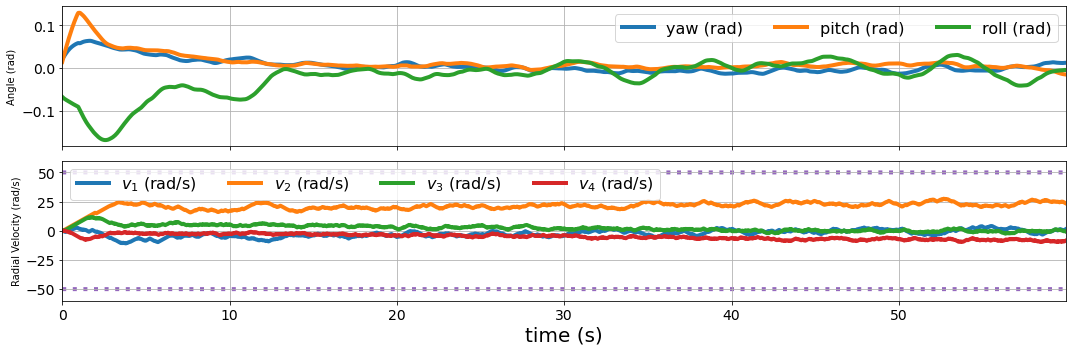

In [104]:
controller = Controller()
######
# simulator.reset(
#     orientation={
#         'yaw': 0.,
#         'pitch': 0.,
#         'roll': 0.,
#     },
#     angular_velocity={
#         'x': 0.,
#         'y': 0.,
#         'z': 0.,
#     },
#     scope_noise=0.1,
# )

simulator.reset(
    orientation=None,
    angular_velocity=None,
    scope_noise=0.1,
)
########
controller.reset()
########
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=60.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)
#########
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_rwvel) = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=4)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=4)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=4)
ax_ori.set_ylabel('Angle (rad)')
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='best')
ax_ori.tick_params(labelsize=14)

# # Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['front_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['back_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['left_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['right_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.set_ylabel('Radial Velocity (rad/s)')
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='best')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwvel.set_xlabel('time (s)', fontsize=20)
ax_rwvel.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
##########
fig.savefig('RequirementsPlotOp.png', transparent=False)

### Controller after simulation ended

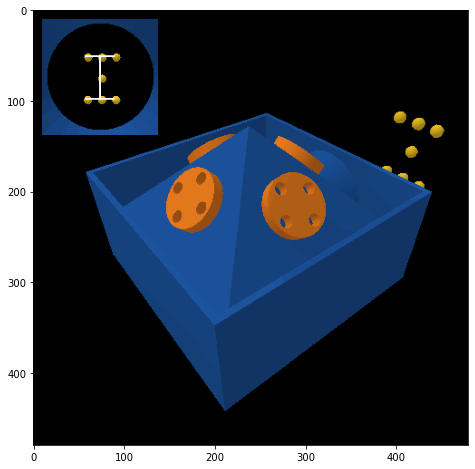

In [105]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)
plt.imsave('OpSnapshot.png', rgba)
plt.show()

## Position of stars over time

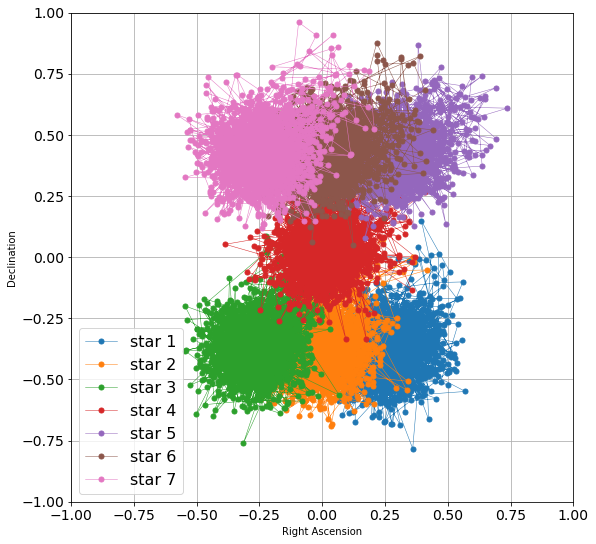

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(-y, z, label=f'star {i+1}', linewidth=0.5, marker='.', markersize=10)
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-1., 1.)
ax.set_xlabel('Right Ascension')
ax.set_ylim(-1., 1.)
ax.set_ylabel('Declination')
fig.savefig('OpStarPositions.png', transparent=False)
plt.show()


# 100 Simulations

In [51]:
def run_simulation():
    controller = Controller()
    simulator.reset(
        orientation=None,
        angular_velocity=None,
        scope_noise=0.1,
    )
    ########
    controller.reset()
    ########
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=65.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
        print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
    )
    t = data['t'][-1]
    if t < .5:
        return False
    else:
        sim_data = data
        
        return sim_data

i = 1000
times = []
rmse = []
initial_yaws = []
initial_pitches = []
initial_rolls = []
while i > 0:
    sim_data = run_simulation()
    if sim_data == False:
        i = i-1
    else:
        times.append(sim_data['t'][-1])
        initial_yaws.append(sim_data['yaw'][0])
        initial_pitches.append(sim_data['pitch'][0]) 
        initial_rolls.append(sim_data['roll'][0])
        
        #RMSE
        y_predicted = sim_data['xhat']
        y_actual = np.array([sim_data['yaw'],sim_data['pitch'],sim_data['roll'],sim_data['w_x'],sim_data['w_y'],sim_data['w_z']])
        MSE = np.square(y_actual.T - y_predicted).mean()
        RMSE = np.sqrt(MSE)
        rmse.append(RMSE)
        i = i-1

896


In [52]:
print('Number of simulations over 0.5 s: ', len(times))

times_failure = []
for i in range(len(times)):
    if times[i] <= 5:
        times_failure.append(times[i])
print('Number of simulations 5 s or below: ',len(times_failure))

times_mid = []
for i in range(len(times)):
    if times[i] > 5 and times[i] < 60:
        times_mid.append(times[i])
print('Number of simulations between 5 s and 60 s: ',len(times_mid))

times_success = []
for i in range(len(times)):
    if times[i] >= 60:
        times_success.append(times[i])
print('Number of simulations 60 s or more: ',len(times_success))

Number of simulations over 0.5 s:  896
Number of simulations 5 s or below:  306
Number of simulations between 5 s and 60 s:  108
Number of simulations 60 s or more:  482


# Plots

## Root Mean Square Error

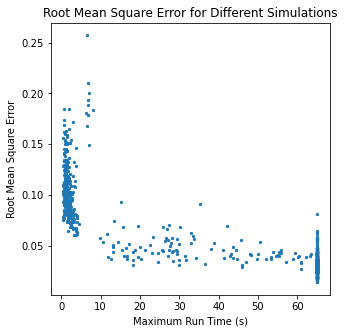

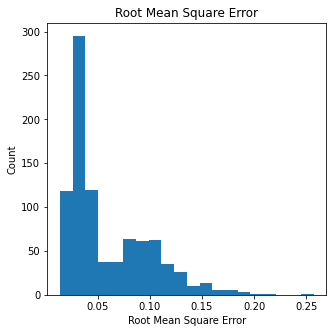

In [115]:
#RMSE vs time
fig = plt.figure(figsize = (5,5))
plt.scatter(times,rmse,s=5)
plt.title('Root Mean Square Error for Different Simulations')
plt.xlabel('Maximum Run Time (s)')
plt.ylabel('Root Mean Square Error')
fig.savefig('RMSEOp', transparent=False)
plt.show()

#RMSE Hist
fig = plt.figure(figsize = (5,5))
plt.hist(rmse,bins=20)
plt.title('Root Mean Square Error')
plt.xlabel('Root Mean Square Error')
plt.ylabel('Count')
fig.savefig('RMSEHistOp.png', transparent=False)
plt.show()

## Analzying Success

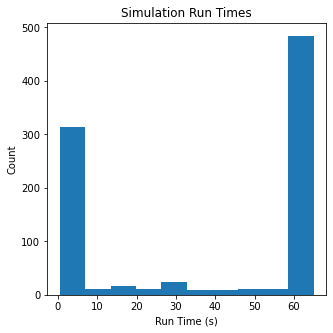

Percent of simulations over 60s: 53.79464285714286


In [116]:
# Simulation runtime Histogram
fig = plt.figure(figsize = (5,5))
plt.hist(times)
plt.xlabel('Run Time (s)')
plt.ylabel('Count')
plt.title('Simulation Run Times')
fig.savefig('HistOp.png', transparent=False)
plt.show()
good_times = [i for idx, i in enumerate(times) if times[idx] >= 60]
print('Percent of simulations over 60s:',len(good_times)/len(times)*100)

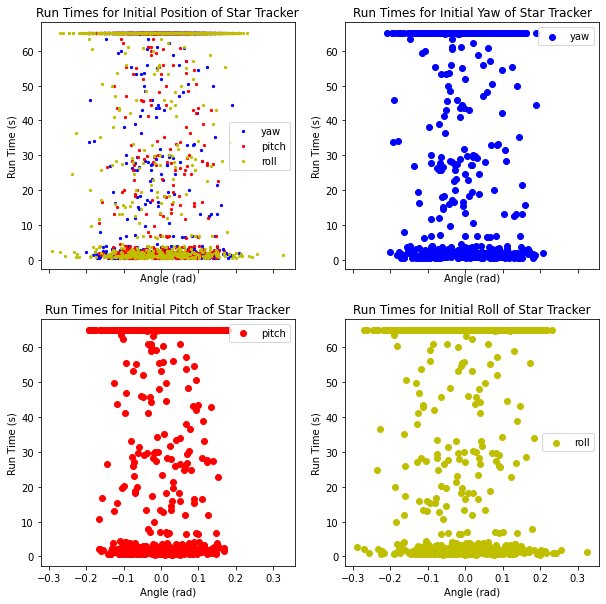

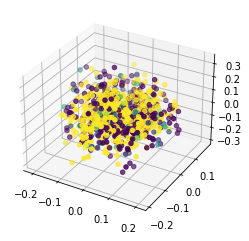

In [113]:
fig, ((ax_all, ax_yaw), (ax_pitch, ax_roll)) = plt.subplots(2, 2, figsize=(10, 10), sharex=True)

ax_all.scatter(initial_yaws,times,s=5, color = 'blue', label = 'yaw')
ax_all.scatter(initial_pitches,times,s=5,color = 'red', label = 'pitch')
ax_all.scatter(initial_rolls,times,s=5,color = 'y', label = 'roll')
ax_all.set_xlabel('Angle (rad)')
ax_all.set_ylabel('Run Time (s)')
ax_all.set_title('Run Times for Initial Position of Star Tracker')
ax_all.legend()

ax_yaw.scatter(initial_yaws,times, color = 'blue', label = 'yaw')
ax_yaw.set_xlabel('Angle (rad)')
ax_yaw.set_ylabel('Run Time (s)')
ax_yaw.set_title('Run Times for Initial Yaw of Star Tracker')
ax_yaw.legend()

ax_pitch.scatter(initial_pitches,times,color = 'red', label = 'pitch')
ax_pitch.set_xlabel('Angle (rad)')
ax_pitch.set_ylabel('Run Time (s)')
ax_pitch.set_title('Run Times for Initial Pitch of Star Tracker')
ax_pitch.legend()

ax_roll.scatter(initial_rolls,times,color = 'y', label = 'roll')
ax_roll.set_xlabel('Angle (rad)')
ax_roll.set_ylabel('Run Time (s)')
ax_roll.set_title('Run Times for Initial Roll of Star Tracker')
ax_roll.legend()
fig.savefig('CombinedInitialOp.png', transparent=False)
plt.show()

from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(initial_yaws, initial_pitches, initial_rolls, c=times)
fig.savefig('3DOp', transparent=False)
plt.show()

## Analyzing error between estimated and actual state measurements

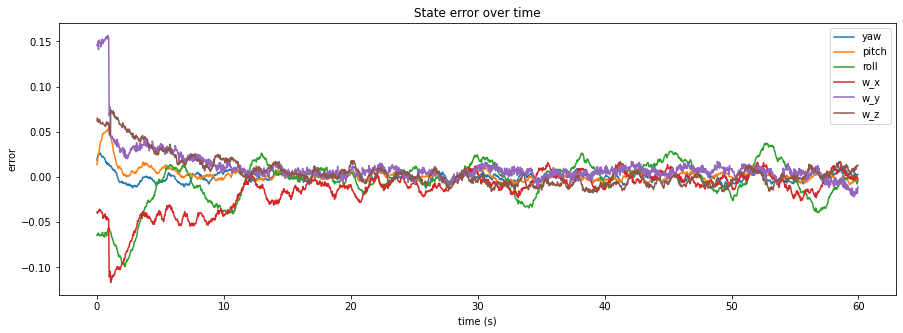

In [112]:

fig = plt.figure(figsize = (15,5))
# Predicted state
y_predicted = data['xhat']
# Actual State
y_actual = np.array([data['yaw'],data['pitch'],data['roll'],data['w_x'],data['w_y'],data['w_z']]).T

plt.plot(data['t'],y_actual-y_predicted,label = ['yaw','pitch','roll','w_x','w_y','w_z'])
plt.legend()
plt.title('State error over time')
plt.xlabel('time (s)')
plt.ylabel('error')
fig.savefig('ErrorOp', transparent=False)
plt.show()